# Ingest Content

## Dependencies

Install the following dependencies first:

In [ ]:
!pip install bs4 jsonlines

## Find all internal URLs

First step is to crawl a domain for all internal links leading to HTML content. Do this until everything is discovered. Enter your domain through adjusting the `url` in `__main__`.

Write the set of discovered URLs from `all_links` to disk, converting them to `jsonl` format for easier processing in the next steps. We'll build upon that `page` dict in the following steps.

In [1]:
import requests
import jsonlines
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
 
def get_domain(url):
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain
 
def get_links(url, response):
    if (response.ok): 
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for link in soup.find_all('a'):
            link_url = link.get('href')
            if link_url:
                absolute_link = urljoin(url, link_url)
                if absolute_link.startswith(domain):
                    links.add(absolute_link)
        return links
    return [] 

def mapLink(url):
    page = dict()
    page['url'] = url
    return page 
 
if __name__ == '__main__':
    url = 'https://ruhmesmeile.com'
    domain = get_domain(url)
    queue = [url]
    visited = set()
    all_links = set()
 
    while queue:
        url = queue.pop(0)
        visited.add(url)
        response = requests.get(url)
        if (response.ok and "text/html" in response.headers['Content-Type']):
            print(url)
            if (url.rstrip("/") not in all_links):
                all_links.add(url.rstrip("/"))
    
            links = get_links(url, response)
            for link in links:
                if link not in visited and link not in queue and '#' not in link and '?' not in link:
                    queue.append(link)
        
    print('All done! ' + str(len(all_links)) + ' links discovered.')

    pages = map(mapLink, all_links)

    with jsonlines.open('pages.jsonl', 'w') as writer:
        writer.write_all(pages)

https://ruhmesmeile.com
https://ruhmesmeile.com/leistungen/single-page-apps
https://ruhmesmeile.com/internetagentur/partner
https://ruhmesmeile.com/referenzen/case-studies/case-study-wolfcraft
https://ruhmesmeile.com/web-frontends/frontend-architektur/atomic-design
https://ruhmesmeile.com/leistungen/frontend-entwicklung
https://ruhmesmeile.com/web-frontends/frontend-architektur/html-komponenten
https://ruhmesmeile.com/web-frontends/frontend-architektur/bem-block-element-modifier
https://ruhmesmeile.com/leistungen/frontend-entwicklung/fuer-unternehmen
https://ruhmesmeile.com/web-frontends/unsere-component-library/vorteile
https://ruhmesmeile.com/glossar
https://ruhmesmeile.com/kontakt
https://ruhmesmeile.com/web-frontends/unsere-component-library/integrationen
https://ruhmesmeile.com/impressum
https://ruhmesmeile.com/
https://ruhmesmeile.com/ueber-uns/ruhmesmeile
https://ruhmesmeile.com/web-frontends/frontend-architektur
https://ruhmesmeile.com/headless-cms
https://ruhmesmeile.com/refer

## More dependencies

Install trafilatura, that will be used to extract the content from pages, and tiktoken to have a first relevant token measurement for complete page content.

In [ ]:
!pip install trafilatura tiktoken

## Extract content from discovered pages

We'll keep Markdown formatting for now. It will be used to split sections from pages by slicing by headlines. 

In [2]:
import re
import jsonlines
import tiktoken
from bs4 import BeautifulSoup
from trafilatura import fetch_url, extract
from markdown import markdown

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

extracted_content = []
with jsonlines.open('pages.jsonl') as pages:
    for page in pages:
        downloaded = fetch_url(page['url'])
        parsed = BeautifulSoup(downloaded)
        ogTitle = parsed.find("meta", property="og:title")
        title = parsed.title.string if parsed.title.string else ogTitle["content"] if ogTitle else page['url']
        result = extract(downloaded, url=page['url'], include_formatting=True)

        if result is None:
            print('couldnt extract:', page['url'])
        else:
            augmented = dict()
            augmented['url'] = page['url']
            
            augmented['content'] = dict()
            augmented['content']['raw'] = markdown_to_text(result)
            augmented['content']['markdown'] = result
            augmented['lines'] = result.splitlines()
            augmented['title'] = title
            augmented['size'] = len(result)
            augmented['token'] = len(enc.encode(result))
            extracted_content.append(augmented)
            print('extracted:', augmented['url'], augmented['title'], str(augmented['token']) + ' Token,', len(result))  

with jsonlines.open('pages_extracted.jsonl', 'w') as pages:
    pages.write_all(extracted_content)
    
print('wrote extracted content to "pages_extracted.jsonl"')

extracted: https://ruhmesmeile.com/internetagentur/partner Partner 230 Token, 678
extracted: https://ruhmesmeile.com/glossar/definition/typo3-fluid TYPO3 Fluid - die Template-Engine - ruhmesmeile Glossar 189 Token, 499
extracted: https://ruhmesmeile.com/glossar/definition/mobile-marketing Was ist Mobile Marketing 280 Token, 777
extracted: https://ruhmesmeile.com/leistungen/frontend-entwicklung Frontend-Entwicklung 1166 Token, 3219
extracted: https://ruhmesmeile.com/typo3-cms/typo3-website-pagespeed TYPO3 Website PageSpeed 4247 Token, 11742
extracted: https://ruhmesmeile.com/glossar/definition/typo3-erweiterungen TYPO3 Extension | TYPO3-Erweiterung 235 Token, 641
extracted: https://ruhmesmeile.com/glossar/definition/typo3-realurl TYPO3 - RealURL - Extension für sprechende URLs 284 Token, 800
extracted: https://ruhmesmeile.com/web-frontends/unsere-component-library/integrationen Integrationen 294 Token, 891
extracted: https://ruhmesmeile.com/glossar/definition/hypertext-markup-language H

extracted: https://ruhmesmeile.com/glossar/definition/webentwicklung Webentwicklung | Web Engineering - ruhmesmeile Glossar 208 Token, 611
extracted: https://ruhmesmeile.com/glossar/definition/webfonts Alles über Webfonts, Webschriften und Webtypografie  404 Token, 1110
extracted: https://ruhmesmeile.com/ueber-uns/frontend-matters Frontend Matters 492 Token, 1299
extracted: https://ruhmesmeile.com/glossar/definition/alt-tag Glossar 398 Token, 1066
extracted: https://ruhmesmeile.com/glossar/definition/content-management-system Definition von Content Management Systemen (CMS) 378 Token, 1047
extracted: https://ruhmesmeile.com/headless-cms/sanity-websites Sanity Websites 1528 Token, 4302
extracted: https://ruhmesmeile.com/referenzen/websites-fuer-immobilien-branche Websites für Immobilien-Branche 615 Token, 1739
extracted: https://ruhmesmeile.com/glossar/definition/headline Headline - Überschriften im HTML - ruhmesmeile Glossar 254 Token, 668
extracted: https://ruhmesmeile.com/glossar/def

## Even more dependencies

Install the BERT extractive summarizer and Sentence Transformers, we'll use these to create summaries as a first step.

In [ ]:
!pip install bert-extractive-summarizer sentence-transformers

## Create SBert summaries

We first create SBert summaries by identifying the most central sentences on a page, concatenating those for a rough first summary.

In [3]:
import tiktoken
from summarizer.sbert import SBertSummarizer

enc = tiktoken.encoding_for_model("text-davinci-003")
model = SBertSummarizer('paraphrase-multilingual-MiniLM-L12-v2')  

extracted_content = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        result = model(page['content']['raw'], num_sentences=5, min_length=60)
        full = ''.join(result)
        print(page['url'], page['title'], str(len(enc.encode(full))) + ' Token,', full)

/home/julrich/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-05 21:48:31.304683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 21:48:31.391463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-05 21:48:31.391480: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on you

https://ruhmesmeile.com/internetagentur/partner Partner 212 Token, Partner von ruhmesmeile
Unser Partner Radikant aus Köln bietet strategische Design- und Corporate Design-Entwicklung auf hohem Niveau. Sollten Kunden neben einer Internetagentur z.B. die Überarbeitung ihres Corporate Designs benötigen oder weitere Designwünsche haben, werden mit Radikant ganzheitliche Unternehmensauftritte entwickelt. Das Unternehmen sitzt ebenfalls in der Schumannstraße in Bonn und steht mit exzellenten Entwicklern und Ressourcen als Partner für Softwarekomponenten zur Verfügung, die nicht mehr im Kontext der Website-Entwicklung liegen und über den Kompetenzbereich einer Internetagentur hinausgehen.
https://ruhmesmeile.com/glossar/definition/typo3-fluid TYPO3 Fluid - die Template-Engine - ruhmesmeile Glossar 186 Token, TYPO3 Fluid
TYPO3 Fluid (zu deutsch flüssig) ist eine Template-Engine (Vorlagen- oder Schablonenmaschine) die vom TYPO3 Team selbst entwickelt wurde. Eine Template-Engine verarbeitet z. 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/typo3-cms/typo3-website-pagespeed TYPO3 Website PageSpeed 289 Token, Absolut wichtig – die Geschwindigkeit einer Website
Zusammenhang von Umsatz und Performance. der PageSpeed oder die Performance einer Website, geben grundsätzlich erst mal an wie groß das Zeitintervall zwischen dem Absenden der Anfrage (Request) und dem vollständigen Laden einer Website ist (Response). First Meaningful Paint (FMP)
Misst die Zeitspanne ab Aufruf des Website, bis der größte Teil des ersten, durch den Benutzer zu sehenden Screens ("Above-the-fold") geladen wurde. Und obwohl über die Zeit eine Reihe weiterer, und auch komplexerer, Messwerte hinzugenommen wurden (zum Beispiel Time to Interactive;  TTI), ergibt sich noch kein übergreifendes, zusammenhängendes Gefühl für die Geschwindigkeit / Performance einer Website. Dieses zeigt detailliert, wo während der Erzeugung der angefragten Website die Zeit verbracht wird.
https://ruhmesmeile.com/glossar/definition/typo3-erweiterungen TYPO3

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/typo3-agentur/typo3-websites TYPO3 Websites 334 Token, TYPO3 Websites
Das Content Management System TYPO3 ist die smarte Lösung um Corporate Websites umzusetzen. Es vereint mächtige Features und Flexibilität mit der Offenheit einer Open Source Lösung. Vorteile von TYPO3
Warum wir auf TYPO3 als Content Management System setzen
Flexible Nutzerverwaltung
Responsive Backend - Arbeiten auf jedem Endgerät
Integration / Anbindung von Schnittstellen
Stabile, etablierte Lösung
Regelmäßige Sicherheitsupdates
Erweiterbar / Skalierbar
Tools zur OnPage Optimierung
Einfache Pflege mehrsprachiger Websites
Ausgezeichnete Website Performance
Wir helfen unseren Kunden dabei, ihre Ziele durch eine bessere Website zu erreichen. Oder das Unternehmen, die Verfügbarkeit seiner Produkte oder der Preis zeichnen sich auf besondere Weise aus. Das Ergebnis sind ohne Brüche integrierte Drittsysteme und Schnittstellen, optimal und differenziert aufbereitete Produktinformationen und eine insg

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/datenschutz Datenschutz 360 Token, Datenschutz
Name und Kontakt des Verantwortlichen gemäß Artikel 4 Abs. Nähere Informationen hierzu erhalten Sie bei Angabe Ihrer personenbezogenen Daten oder untenstehend in der Beschreibung des Angebotes. Werden personenbezogene Daten verarbeitet, um Direktwerbung zu betreiben, so haben SIe das Recht, jederzeit Widerspruch gegen die Verarbeitung Sie betreffender personenbezogener Daten zum Zwecke derartiger Werbung einzulegen; dies gilt auch für das Profiling, soweit es mit solcher Direktwerbung in Verbindung steht. (3) Sie können die Speicherung der Cookies durch eine entsprechende Einstellung Ihrer Browser-Software verhindern; wir weisen Sie jedoch darauf hin, dass Sie in diesem Fall gegebenenfalls nicht sämtliche Funktionen dieser Website vollumfänglich werden nutzen können. Ihrer IP-Adresse) an Google sowie die Verarbeitung dieser Daten durch Google verhindern, indem sie das unter dem folgenden Link verfügbare Browser-Plug

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/typo3-cms/typo3-als-plattform TYPO3 als Plattform 548 Token, TYPO3 als Plattform
Wieso bietet gerade TYPO3 die richtigen Vorraussetzungen für die Entwicklung moderner, performanter Corporate Websites und gleichzeitig die Bordmittel um komplexere, integrative Webprojekte umzusetzen? So gibt es alle 1 1/2 Jahre eine neue Hauptversion von TYPO3, welche neue Features einführt, und im Zweifel nicht komplett abwärts-kompatibel ist. Dieser konzentriert sich erneut auf weitere Qualitätsverbesserungen und die fortschreitender Konsolidierung des CMS-Kerns:
https://typo3.org/article/x-marks-the-spot-typo3-v100-is-here/
https://typo3.org/article/typo3-version-101-on-the-high-seas/
Interessante Initiativen
Neben der Koordinierung der langfristigen Entwicklung mit dem Kernentwickler-Team versuchen Initiativen bereits möglichst frühzeitig einsetzbare Versionen von Extensions / Änderungen zu veröffentlichen. Erste Bestrebungen wurden bereits im Rahmen von TYPO3 9.5 LTS realisie

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/typo3-cms/typo3-agentur/typo3-update TYPO3 Update 248 Token, Es gibt viele gute Gründe das Content Management System (CMS) der eigenen Website mit einem TYPO3 Update aktuell zu halten. Da die Versionen der Reihe nach aktualisiert werden müssen, sind die Update-Kosten ohnehin gleich. Das Update / Upgrade zwischen zwei Hauptversionen ist leider immer ein recht aufwendiger Vorgang, da eine TYPO3 Installation in der Regel nicht nur den TYPO3 Core, sondern auch diverse Extensions umfasst. Livegang
Wenn Sie zufrieden mit dem Ergebnis des Testsystems sind und ein erfolgreicher review stattgefunden hat übernehmen wir diesen Stand und übertragen Ihn auf das Livesystem. Updates für von uns entwickelte TYPO3-Systeme können zu fest kalkulierbaren Preisen durchgeführt werden.
https://ruhmesmeile.com/glossar/definition/web-monitoring Web-Monitoring - Online-Beobachtung und -Analyse 108 Token, Web-Monitoring
Unter Web-Monitoring versteht man die Beobachtung, Analyse und Aufber

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/glossar/definition/metadaten Bedeutung von Metadaten für SEO - ruhmesmeile Glossar 248 Token, Metadaten
Metadaten sind Zusatzinformationen zu Hauptdaten, aber nicht diese Daten selbst. Metadaten von Webseiten werden im Kopf-Bereich eines HTML-Dokuments eingetragen. Sie helfen dabei die Durchsuchbarkeit des World Wide Web bzw. Früher wurden Metadaten missbraucht um bei Suchmaschinen möglichst weit oben gelistet zu werden. Zu den bekannten Metadaten gehören:
- Meta Name Keywords: gibt Stichwörter oder Themen an, die auf der Webseite vorkommen
- Meta Name Description: enthält eine kurze Beschreibung des Inhalts
- Meta Name Author: benennt den Autor
- Meta Name Robots: gibt Anweisungen für Webcrawler
Erfahren Sie mehr über Suchmaschinenoptimierung unter Online-Marketing Beratung.
https://ruhmesmeile.com/web-frontends/design-system-implementierung/storybook Storybook 208 Token, Storybook: Ein Tool zur Entwicklung von UI Komponenten
Storybook ist eine Software-Bibliot

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/glossar/definition/adwords Wie funktioniert die Google AdWords Werbung? 269 Token, AdWords
AdWords, ein Begriff der sich aus dem Englischen „Adverts“ (Anzeigen) und „Words“ (Worte) bildet, ist ein Werbeanzeigen-System von Google. Man findet sie ganz oben auf der Seite, wo sie leicht farblich hinterlegt sind oder in einer Spalte am rechten Bildschirmrand. Der Preis berechnet sich über ein Bietsystem: Der Inserent bietet einen Maximalpreis, den er bereit ist für einen Klick auf seine Textanzeige zu bezahlen. Einer Überschrift mit 25 Zeichen, zwei Zeilen Beschreibung mit jeweils 35 Zeichen und einem Link auf das Ziel. AdWords können nicht nur auf der Ergebnisseite einer Google-Suche sondern auch auf einer der zahlreichen Websites aus dem Google-Netzwerk wie z.B. YouTube geschaltet werden.
https://ruhmesmeile.com/glossar/definition/first-contentful-paint-fcp Glossar 116 Token, First Contentful Paint (FCP)
Bezeichnet die Zeit, in welcher das erste Element (bspw. Bild

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/summarizer/cluster_features.py:149: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  model = self._get_model(k).fit(self.features)
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julri

https://ruhmesmeile.com/glossar/definition/organische-suchergebnisse Was sind organische Suchergebnisse? 242 Token, Organische Suchergebnisse
Bei den organischen Suchergebnissen handelt es sich um die Suchergebnisse auf einer Suchergebnisseite (englisch Search Engine Result Page, kurz SERP) die nicht bezahlt sind, wie z. B. die Anzeigen des Google-AdWords Programms, die man über oder rechts neben den SERPs findet. Dieser setzt sich aus einer Vielzahl von Qualitätsfaktoren zusammen. Ziel der Suchmaschinenoptimierung (englisch Search Engine Optimisation, kurz SEO) ist es die Position innerhalb dieser organischen Liste zu verbessern. Performanz spielt aus unserer Sicht eine entscheidende Rolle im Ranking. Dank unseres Frontend-Frameworks kickstartds.com und einer modernen JAMStack-Architektur sind unseren Websiten blitzschnell geladen.
https://ruhmesmeile.com/glossar/definition/custom-content-elemente-cce Glossar 294 Token, Custom Content Elemente CCE
Der Mercedes unter den Inhaltselement

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/glossar/definition/alexa-rank Die Bedeutung des Alexa Rank - ruhmesmeile Glossar 143 Token, Alexa Rank
Mit dem Alexa Rank werden die festgestellten Besucherzahlen im Web ausgewertet und auf diese Weise die 1.000.000 am meisten besuchten Domains weltweit ermittelt. Der Alexa Rank ist somit auch ein Indikator für die Popularität der eigenen Website. Verbesserungen des eigenen Ranks können durch Optimierungen der Website erreicht werden. Mehr zur Optimierung des eigenen Rankings finden Sie auf unserer Seite Online Marketing Beratung.
https://ruhmesmeile.com/typo3-cms/typo3-agentur TYPO3 Agentur 289 Token, TYPO3 Agentur ruhmesmeile
mehr als 10 Jahre Erfahrung mit TYPO3 Websites
Als TYPO3 Agentur setzen wir mit unserem erfahrenen Entwickler-Team für zahlreiche Anforderungen seit vielen Jahren auf TYPO3. Als TYPO3 Agentur realisieren wir für Sie auch passgenaue Websites, die nach und nach, mit Ihrem Geschäftsmodell oder Ihren Möglichkeiten und Anforderungen, wachsen. 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/headless-cms/jamstack JAMstack 289 Token, JAMstack Website Architektur
Wofür steht und was bedeuetet JAM-Stack? Die auf diese Weise gepflegten Daten finden auf zwei Arten ihren Weg in die generierte Website:
- Während der Generierung der initialen Ansichten (für statische Informationen; z.B. Beschreibungstexte)
- Während dem Besuch der Website (für dynamische Informationen; z.B. Werte als Grundlage für die Berechnung eines Widgets)
Vorteile einer JAM-Stack Architektur
JAM-Stack Website sind aus verschiedenen Gründen immer poulärer und beliebter. Das Repository stellt also nicht nur den Code, sondern auch die Content API bereit. Redaktuere können jedoch separate, einfach zu bedienende Eingabemasken, also eine CMS-Oberfläche haben.) Nachteile „Git based“:
- Es ist schwerer den gleichen Inhalt für verschiedene Frontends zu nutzen.
https://ruhmesmeile.com/glossar/definition/sitemap Was sind HTML oder XML Sitemaps? - ruhmesmeile Glossar 261 Token, Sitemap
Als Sitemap

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/web-frontends/frontend-architektur/sass-itccs SASS & ITCCS 309 Token, Modulares CSS für modulare Designs
Wie SASS und ITCSS helfen Design strukturiert in CSS zu übersetzen
Herausforderung: Wie teile ich mein CSS auf? Das Ergebnis ist eine automatisch gegebene Konsistenz aller Buttons, oder entsprechend verallgemeinert des gesamten Design Systems! An genau dieser Stelle springt SASS ein, und erweitert CSS um zusätzliche Regeln und Funktionen um exakt solche modularisierten Regeln zu ermöglichen. Dies hat sich als generelle Best Practice bei der Entwicklung von Komponenten etabliert, und ist mit reinem CSS nicht ohne weitreichende Code-Duplikation möglich. Der fehlende Baustein - BEM
Block, Element, Modifier, ein Schema zur Benennung
Während Nesting, Partials und Mixins bereits die technischen Möglichkeit bieten größere Strukturen zu modularisieren, so sagen sie aber noch nichts darüber aus wie ich das tue.
https://ruhmesmeile.com/glossar/definition/design-system 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/kontakt Kontakt 159 Token, Daniel Ley
Jonas Ulrich
Kontakt
Wir freuen uns auf Ihre Nachricht
Unser Standort in der Bonner Südstadt
ruhmesmeile GmbH
Schumannstraße 15
53113 Bonn
0228 / 688 966-20
mail@ruhmesmeile.com
Wir helfen Ihnen gerne weiter! Daniel Ley
Jonas Ulrich
Wir freuen uns auf Ihre Nachricht
ruhmesmeile GmbH
Schumannstraße 15
53113 Bonn
0228 / 688 966-20
mail@ruhmesmeile.com
https://ruhmesmeile.com/leistungen Frontend-Entwicklung 240 Token, Frontend-Entwicklung
Modernste Frontend-Entwicklung
Wir entwickeln Frontends für jeden Einsatz! Deshalb ist die Frontend-Entwicklung darauf ausgelegt, eine aus User-Sicht, möglichst übersichtliche Oberfäche zu schaffen, sodass sich eine Website bzw. Als Grundlage für Projekte verwenden wir unsere hauseigene Pattern Library, die dem Prinzip des Atomic Design folgt. Welche Schritte und Wege dorthin führen erarbeiten wir gemeinsam mit Ihnen. Backend-Integration des Frontends
Wie gut ein Frontend technisch integriert 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/web-frontends/frontend-architektur Frontend-Architektur 353 Token, Frontend Architektur
Die Ansprüche an die Entwicklung von (Web-)Frontends ist hoch: Modularität, Design-Qualität, Responsivität, Kompatibilität und die Mächtigkeit der anzubindenden Backend-Technologie erfordern ein planvolles und systematisches Vorgehen bei der Entwicklung eines Frontends. Viele Webframeworks und Technologien bringen dazu bereits fertige Konzepte oder Annahmen mit. Es gilt dann vor der eigentlichen Entwicklung des Frontends innerhalb der Vorgaben der Technologie ein passendes Vorgehen und die zugehörige Frontend-Architektur auszugestalten. Eine Frontend-Architektur umfasst:
- Definition von Qualitätsstandards
- Definition von Prozessen und Workflows
- Der Aufbau einer Frontend-Build-Pipeline, von Toolchains und Build-Prozessen
- Ein Konzept für Frontend-Testing und Qualitätssicherung
Welche Rolle spielen Oberflächen in Headless-Architekturen? Headless-Architekturen, die die Benu

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/headless-cms Netlify CMS Websites 239 Token, Netlify CMS ist ein Open Source CMS, welches vom Cloud-Anbieter Netlify entwickelt und kostenlos zur Verfügung gestellt wird. Auf Basis der gepflegten Inhalte kann dann mit dem JAM-Stack-Ansatz eine Website generiert werden. Perfekt für Anwendungsfälle bei denen Ladezeit-Performance und Verfürgbarkeit eine enstcheidende Rolle spielen. Eine gewisse Unabhängigkeit gehört aus unserer Sicht zum Wertversprechen von Headless CMS. Features bei der Nutzung von Netlify CMS auf dem CDN von Netlify
Das Ergebnis einer mit Netlify CMS erstellten Website kann als statische Website auf jedem normalen Webhosting oder CDN (Content Delivery Network) betrieben werden. (
https://ruhmesmeile.com/glossar/definition/jamstack Glossar 195 Token, JAMstack
JAMstack ist die Bezeichnung für eine technische Architektur 7 Software Architektur, um Websites zu bauen. Das Akronym JAM steht für das Architektur-Muster der Software:
• J (= JavaScript) fü

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/glossar/definition/webentwicklung Webentwicklung | Web Engineering - ruhmesmeile Glossar 185 Token, Webentwicklung
Webentwicklung (Web Engineering) bezeichnet die Weiterentwicklung oder die Erstellung neuer Websites, Webshops, Apps oder ähnlicher Anwendungen in technischer Hinsicht. Die Webentwicklung ist also der Weg zu der geplanten individuellen Weblösung. Für eine erfolgreiche Webentwicklung sind die neuesten Webtechnologien unabdingbar. Abzugrenzen ist die Webentwicklung vom Webdesign, welche sich mit der optischen Gestaltung der Anwendung befasst. Mehr zu unseren Leistungen im Bereich Webentwicklung finden Sie auf der Seite Web Technology.
https://ruhmesmeile.com/glossar/definition/webfonts Alles über Webfonts, Webschriften und Webtypografie  240 Token, Webfonts
Als Webfonts, Webschriften oder auch Webtypografie bezeichnet man den Gebrauch von Schriftarten (englisch "Fonts") auf Internetseiten. In den Anfängen von HTML wurden diese durch die jeweiligen Ein

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/headless-cms/sanity-websites Sanity Websites 259 Token, Content Management mit Sanity Studio CMS
Was ist Sanity Studio? Sanity.io versteht sich vorrangig als eine Plattform für strukturierte Inhalte. So kann man beispielsweise APIs nutzen, um optimale Bearbeitungsworkflows zu erstellen und Inhalte zwischen Plattformen, Systemen oder anderen Applikationen auszutauschen. Static-site Generation mit next.js und Sanity Studio - das JAM-Stack Prinzip
Die Idee bei dem Konzept ist es, alle Inhalte, egal ob strukturierte Daten oder per Sanity Studio erstellte Texte, in statische Webseiten zu generieren, die ganz ohne den Ballast eines dynamisches Backend ausgeliefert werden. Live Preview im Backend
Sanity ♥ kickstartDS
Das Live-Preview hilft dem Redaktionsteam Inhalte auf Ihrer Website oder -Anwendung sofort zu sehen und zu testen.
https://ruhmesmeile.com/referenzen/websites-fuer-immobilien-branche Websites für Immobilien-Branche 264 Token, Websites für Immobilien-Branch

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/leistungen/frontend-entwicklung/fuer-agenturen Für Agenturen 369 Token, Frontend Services für Agenturen und Softwarehersteller
Planbarkeit und Qualität für Websiteprojekte
Unser Ziel ist, dass Agenturen und Softwarehersteller sich bei Website-Frontends auf das konzentrieren können was wirklich wichtig ist: Sich vom Wettbewerb zu differenzieren. Mit uns werden wichtige "Hygiene-Faktoren" beherrschbar:
- Ladezeitperformance
- Geräte und Browserkompatibilität
- Frontend-Architekturen, die die richtigen Handlungsoptionen erlauben
- Frontend-Library-Integrationen
- Wartbare und erweiterbare Code-Strukturen
Wir sorgen für die Grundlagen, für die 80%, Sie konzentrieren sich auf Ihren Kunden! Sie können auf zwei Ebenen angepasst werden:
- Durch (Web-)Designer, indem die Variablen des den Komponenten zu grunde liegenden Design-Systems angepasst werden. Durch dieses "Code-First"-Vorgehen kommen Sie sehr schnell zu Ergebnissen. Kickstart
Unser Beratungs-Paket für bessere F

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/web-frontends/frontend-architektur/html-komponenten HTML Komponenten 359 Token, HTML Komponenten als Basis
Standards als Grundlage für maximale Kompatibilität
Was ist unter HTML Komponenten zu verstehen? Im Gegensatz zu diesen Zielplattformen unterliegen Interfaces für Websites weniger System-bedingten Erwartungen an das User-Interface (in Design und Funktion). Ein Vorteil davon Komponenten tatsächlich zentral in HTML zu entwickeln (über CSS um Design ergänzt, und über JavaScript mit Interaktivität angereichert) ist, das im Ergebnis eine Framework-agnostische Sammlung entsteht. Informationen werden zusätzlich bei korrekter Umsetzung so ausgezeichnet, dass sowohl Suchmaschinen und Social Networks diese auslesen können, als auch eine optimale Zugänglichkeit im Rahmen der Website-Accessibility gegeben ist. Nutzt man zusätzlich als Basis der Entwicklung eine etablierte Kombination aus technischen Entscheidungen und Prozessen, in Form einer Component Library wie dem 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/websites/online-marketing-beratung Online Marketing Beratung - Sparring mit ruhmesmeile 246 Token, Online Marketing Beratung
Wie funktioniert erfolgreiches B2B Online Marketing? - Es braucht ein Content-Kreations-Konzept (für Text, Bild und weitere Medien)
- Attraktives und passendes Bildmaterial
- Infografiken
- Downloads
- Bewegtbildinhalte
Content is King
Ja, aber es gibt einiges zu beachten! - Sind weiterführende Informationen zu den Produkten und Services vorhanden (Eigenschaften, Maße, Qualitätsmerkmale, Datenblätter o.ä.) B2B-Website-Advanced
- Werden anwendungsspezifische oder branchenspezifische Informationen angeboten? Ergebnis zwischen
6 und 9 Punkten: Die Website ist gut aufgestellt und sollte einen nachweisbaren Beitrag zum Absatz des Unternehmen leisten.
https://ruhmesmeile.com/typo3-cms/typo3-agentur/typo3-solr-betrieb TYPO3 Solr Betrieb 177 Token, Die Solr (gesprochen Solar) Suche von der Apache Software Foundation ist eine Open Source-Suchserver

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/typo3-cms/typo3-agentur/typo3-relaunch TYPO3 Relaunch 361 Token, Dem englischen Begriff nach ist der Relaunch eine Strategie, um den Lebenszyklus eines Produktes zu verlängern oder einen neuen Lebenszyklus durch Anpassungen des Angebotes zu schaffen. Ein Relaunch kann im allgmemeinem unterschiedliche Ziele verfolgen:
- Verlängern des Produkt Lebenszyklus
- Stoppen eines möglichen Preisverfalls
- Verkaufszahlen erhöhen und eine weitere Wachstumsphase einleiten
- Absatzrückgänge stoppen
- Ein nicht erfolgreiches Produkt überarbeiten und später wieder am Markt positionieren
Welche Arten von Relaunches gibt es? - wenn das System nicht reponsiv darstellbar ist (responsives Webdesign und Mobil First). Weiterleitungen und GoLive des Systems
Kurz bevor die Seite Live geht werden durch ruhmesmeile oder dem Projektverantwortlichen auf der Kundenseite die Weiterleitungsliste erstellt. Damit ein umfassender Relaunch zukünftig nicht mehr notwendig ist, entwickeln wir bei ruh

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/glossar/definition/broken-links Was sind Broken Links? - ruhmesmeile Glossar 137 Token, Broken Links
Wenn Dateien/Webseiten verschoben oder gelöscht werden, können alte Links, die nach wie vor auf diese Dateien/Webseiten zeigen, kein Ziel mehr auf dem Server finden. Im ruhmesmeile Servicereport wird geprüft, ob links auf der Webseite "broken" sind. Mehr zu unseren Service- und Supportleistungen finden Sie auf der Seite kontinuierlicher Verbesserungsprozess.
https://ruhmesmeile.com/glossar/definition/sprechende-url Sprechende URL - nutzerfreundlich und SEO-relevant 220 Token, Sprechende URL
URLs (Uniform Resource Locator - englisch für einheitlicher Quellenanzeiger) sollten nach Möglichkeit nicht aus Indexnummern (z.B. php?=12345) bestehen, sondern "sprechend" sein - also aus klaren Textbausteinen bestehen. Dies ist sowohl aus Gesichtspunkten der Suchmaschinenoptimierung besser als auch nutzerfreundlicher als "kryptische" URLs. Die sogenannten sprechenden URLs we

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://ruhmesmeile.com/typo3-cms/typo3-agentur/typo3-schulung TYPO3 Schulung 270 Token, TYPO3 Schulung und Support
Als TYPO3 Agentur bieten wir für das CMS TYPO3 Schulungen für unterschiedlichste Anforderungen an. Dabei schneiden wir die Schulung immer individuell auf Ihre Wünsche und Anforderungen zu. Die von uns vermittelten Inhalte und Informationen basieren auf Jahren der TYPO3-Erfahrung, zahlreichen erfolgreichen Projekten sowie der stetigen Weiterbildung unserer Mitarbeiter. TYPO3 Schulung nach Ihrem Website Relaunch
Im Anschluss an einen Website Relaunch auf TYPO3-Basis empfehlen wir grundsätzlich eine entsprechende Schulung, unabhängig davon, ob Sie zuvor bereits mit TYPO3 gearbeitet haben oder nicht. TYPO3 bietet tausende Funktionen und Features, von denen Sie in der Regel nur einen Bruchteil benötigen.
https://ruhmesmeile.com/web-frontends/unsere-component-library/component-library-anfrage Component Library Anfrage 0 Token, 


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://ruhmesmeile.com/leistungen/design-system-starterkit Design System Starterkit 349 Token, kickstartDS - unser Framework für digitale Design Systeme
Unsere
ruhmesmeile Frontend Component Library haben wir zu kickstartDS weiterentwickelt. Die Komponenten können beliebig erweitert und angepasst werden. Darüberhinaus ist kickstartDS mit beliebigen Technologien kombinierbar (Individualentwicklungen, TYPO3, Ruby on Rails, Angular, Vue.js; jede Backendtechnologie die Templating erlaubt)
- In beliebig vielen, unterschiedlichen Websites und Apps / PWAs einbaubar, um eine übergreifend hohe UI-/UX-Qualität zu erreichen
- Hooks und Konfigurationsmechanismen, in die eigene Funktionalität eingehängt werden kann. - Optimierung des Critical Rendering-Paths; alle für die initiale Ansicht notwendigen Regeln werden isoliert ausgegeben, und können direkt mit dem initialen HTML ausgeliefert werden
- Automatisiert getestete Crossbrowser-Kompatibilität. Wir sind uns jedoch in einer Sache sicher:
kickst

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/summarizer/cluster_features.py:149: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  model = self._get_model(k).fit(self.features)
/home/julri

https://ruhmesmeile.com/headless-cms/netlify-cms-websites Netlify CMS Websites 239 Token, Netlify CMS ist ein Open Source CMS, welches vom Cloud-Anbieter Netlify entwickelt und kostenlos zur Verfügung gestellt wird. Auf Basis der gepflegten Inhalte kann dann mit dem JAM-Stack-Ansatz eine Website generiert werden. Perfekt für Anwendungsfälle bei denen Ladezeit-Performance und Verfürgbarkeit eine enstcheidende Rolle spielen. Eine gewisse Unabhängigkeit gehört aus unserer Sicht zum Wertversprechen von Headless CMS. Features bei der Nutzung von Netlify CMS auf dem CDN von Netlify
Das Ergebnis einer mit Netlify CMS erstellten Website kann als statische Website auf jedem normalen Webhosting oder CDN (Content Delivery Network) betrieben werden. (


## Extract sections from markdown page content

We'll extract sections from our pages by splitting along markdown headlines (# to ######).

In [4]:
import re
import json
import tiktoken
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from typing import Set
from markdown import markdown
from nltk.tokenize import sent_tokenize

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(enc.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = []

def extract_sections(
    page_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a kickstartDS page, discarding the references and other low information sections
    """
    if len(page_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("#+ .*", page_text)
    for heading in headings:
        page_text = page_text.replace(heading, "#+ !!")
    contents = page_text.split("#+ !!")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("#", "").strip())
        ncontents.append(markdown_to_text(content).replace('\n', ' '))
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

outputs = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        outputs += extract_sections(page["content"]["markdown"], page["title"])
        
df = pd.DataFrame(outputs, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

result = df.to_json(orient="records")
parsed = json.loads(result)

with jsonlines.open('pages_extracted_sections.jsonl', 'w') as pages:
    pages.write_all(parsed)
    
print('Extracted ' + str(len(parsed)) + ' sections from pages.')

Extracted 298 sections from pages.


## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
!pip install top2vec "top2vec[sentence_encoders]"

## Create topics

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

2023-03-05 21:49:50,721 - top2vec - INFO - Pre-processing documents for training
2023-03-05 21:49:50,776 - top2vec - INFO - Creating joint document/word embedding


298 documents added for topic generation.


2023-03-05 21:50:01,078 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-05 21:50:06,504 - top2vec - INFO - Finding dense areas of documents
2023-03-05 21:50:06,510 - top2vec - INFO - Finding topics



3 topics discovered.

Top 3 topics returned for keyword search "kickstartDS":

Top 10 words by similarity to keyword "kickstartDS":
starterkit 0.6307858225699465
extrem 0.5677523647355116
schnellen 0.5510222232575366
kombinieren 0.5221501444791038
anpassbaren 0.5142759494865056
markenkonforme 0.4990224277829094
perfekte 0.4952552904654414
bibliothek 0.4920471081640726
flexibel 0.449327348333935
konsistente 0.4382663877134771

Top 10 sections for topic #1
Document: 111, Score: 0.5626989603042603
-----------
TYPO3 Upgrade-Garantie UNSERE UPGRADE- UND WARTUNGSGARANTIE FÜR TYPO3 Wir bieten unseren Kunden an, alle Major-Upgrades (LTS-Versionen) von TYPO3 für mehrere Jahre zu einem fest kalkulierbaren Preis durchzuführen. Im Rahmen der Upgrades bringen wir nicht nur das TYPO3-System auf Stand, sondern liefern dieses auch mit einer aktuellen Version unseres Frontends aus. Das Ergebnis ist eine Website, die rundum auf den neuesten Stand gebracht wurde.
-----------

Document: 259, Score: 0.546

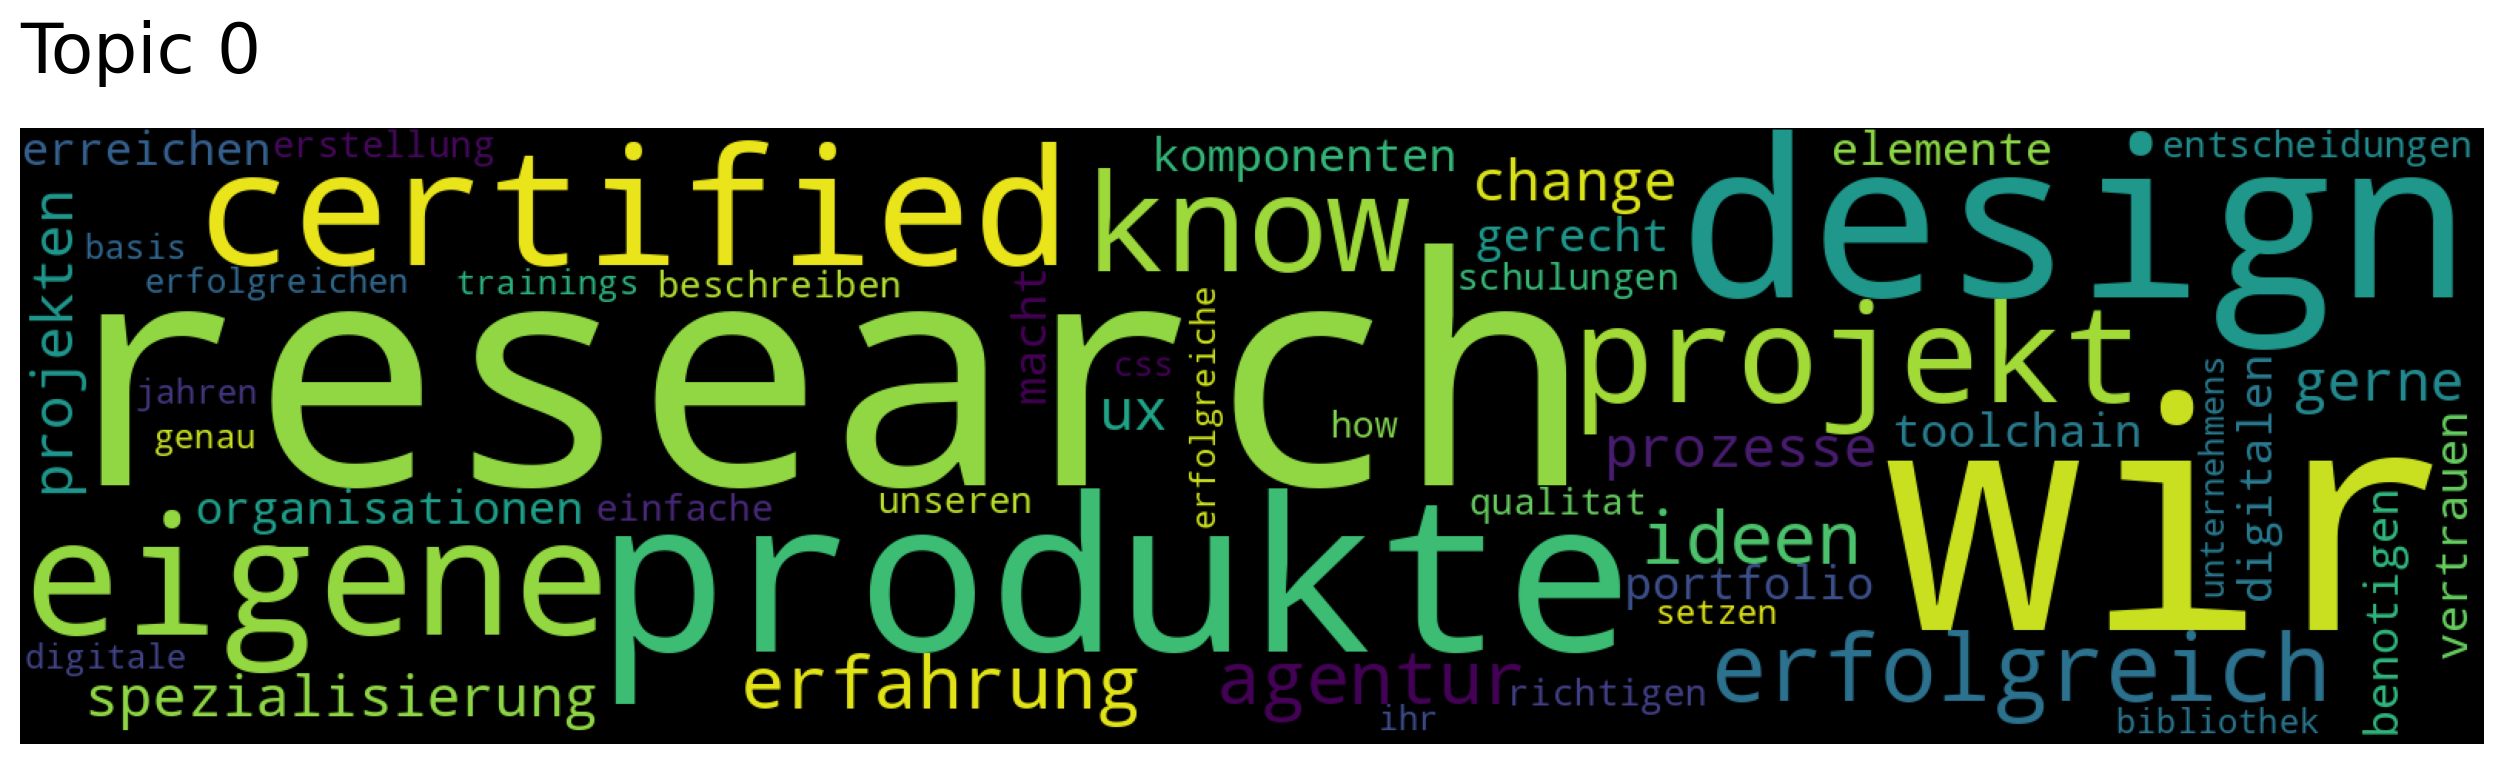

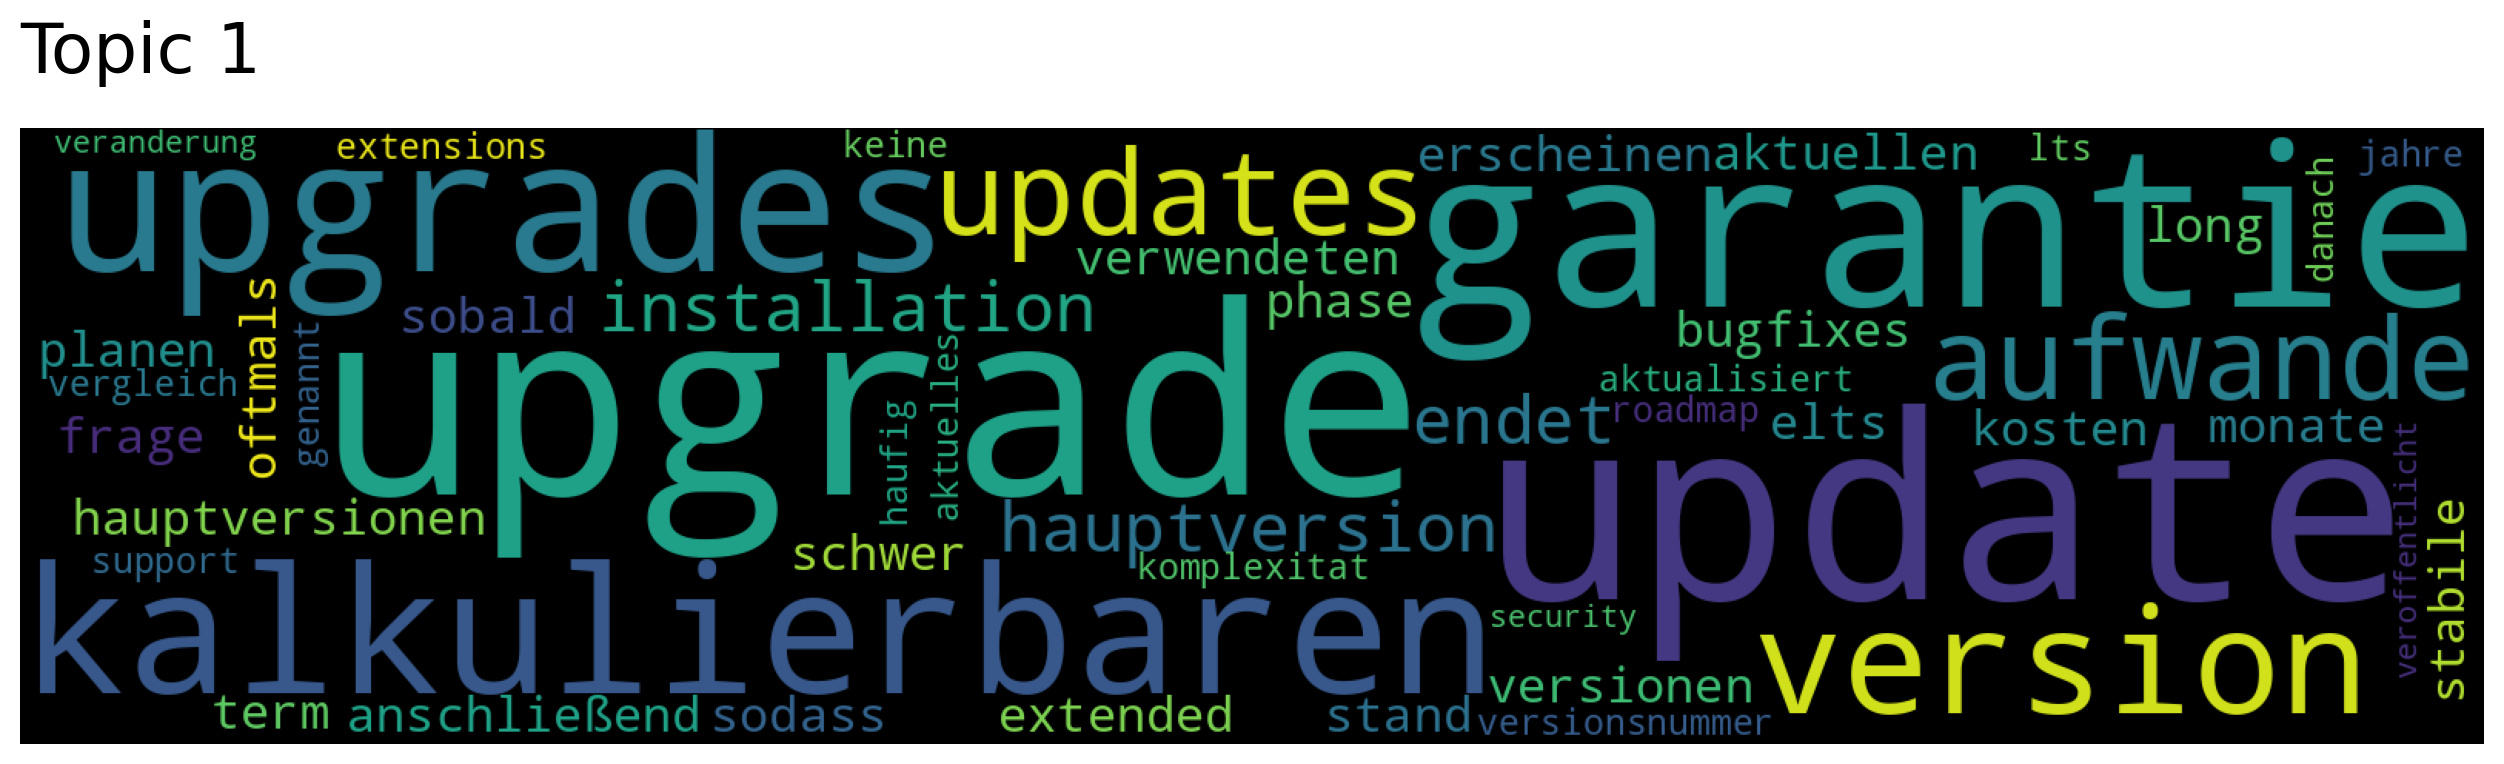

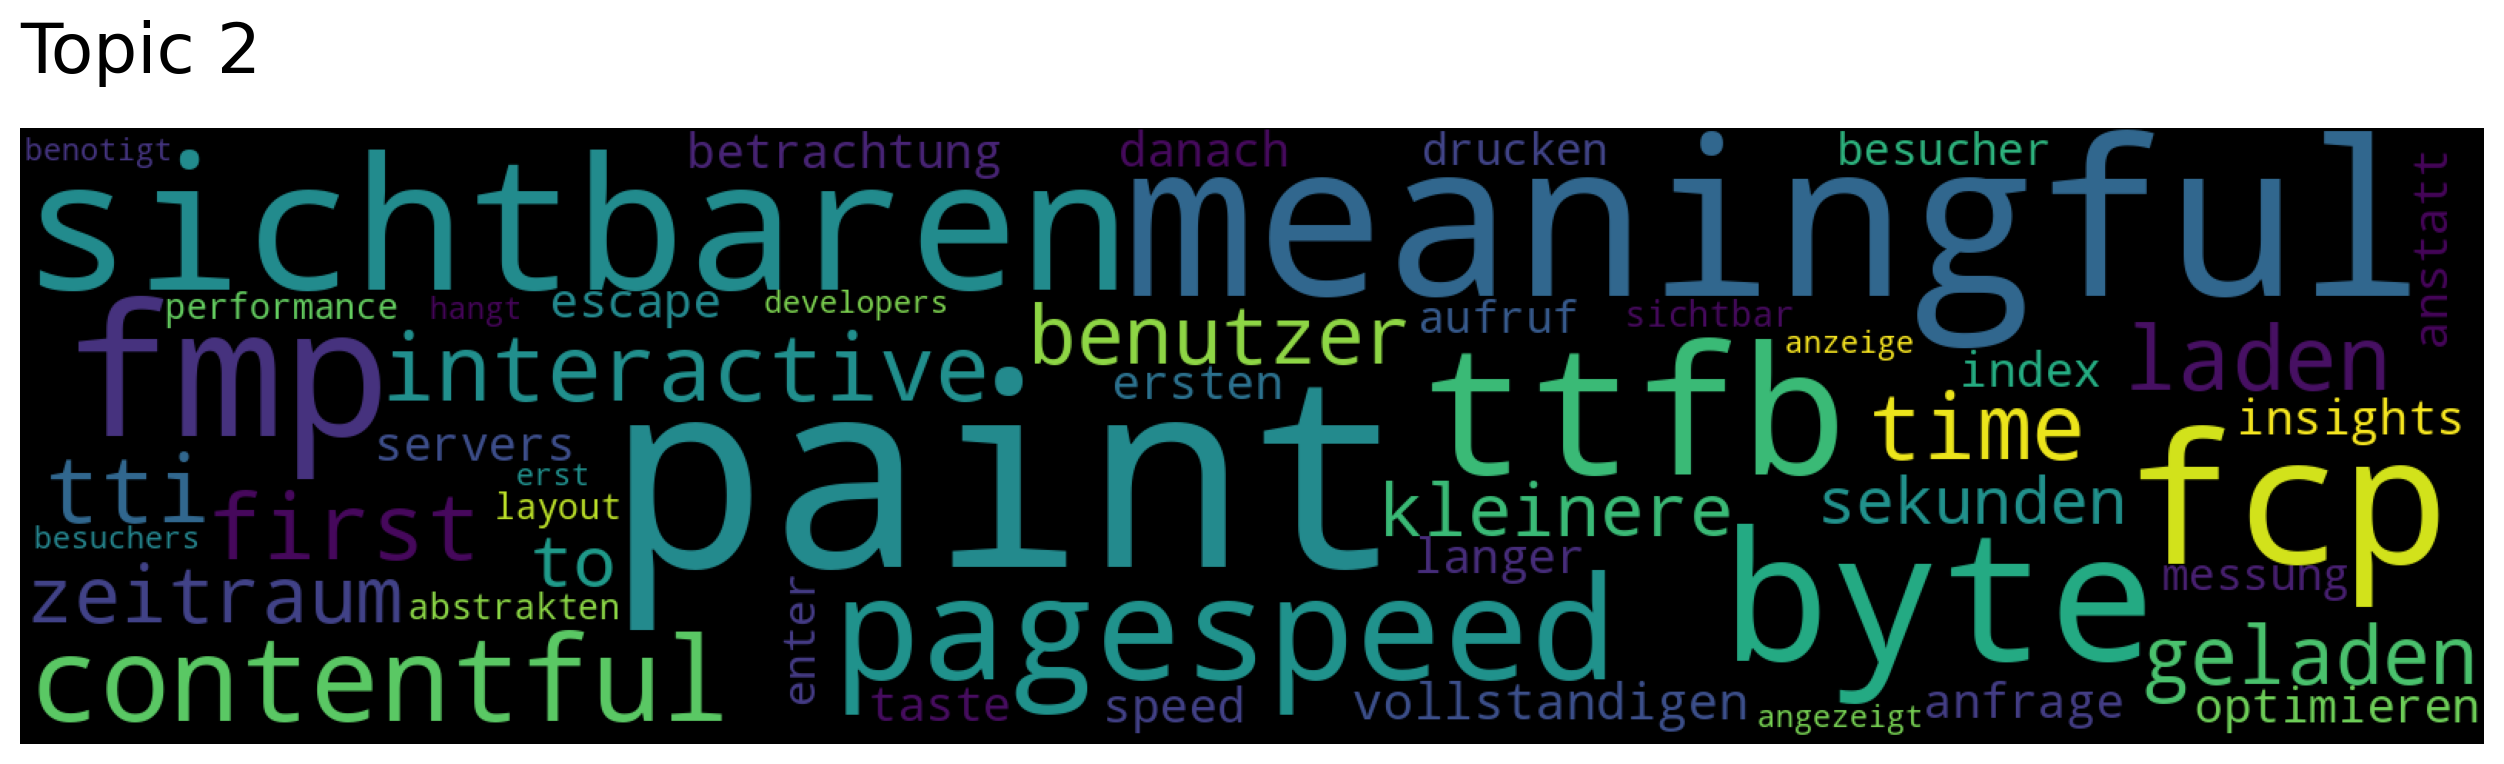

In [5]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw']

documents = list()
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as sections:
    for section in sections:
        documents.append(section['title'] + ' ' + section['heading'] + ' ' + section['content'])
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8, min_count=3)

print()
print(str(model.get_num_topics()) + ' topics discovered.')

print()
print('Top 3 topics returned for keyword search "kickstartDS":')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["kickstartDS"], num_topics=3)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 10 words by similarity to keyword "kickstartDS":')
words, word_scores = model.similar_words(keywords=["kickstartDS"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 10 sections for topic #1')
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

passages = []
with jsonlines.open('page_content.jsonl') as reader:
    for page in reader:
        #Add all paragraphs
        passages.extend(page['paragraphs'])

        #Only add the first paragraph
        #passages.append(page['paragraphs'][0])        

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np

# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
# This function will search all kickstartDS pages for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-5 lexical search (BM25) hits")
    for hit in bm25_hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-5 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))